# EO for constrained optimization
This notebook contains two sections.
The first one allows running each implemented method on an optimization problem of choice.
The second one contains interactive benchmarking result viewing interface, where an average performance of any combination of implemented methods can be compared.

The problems are from the web page: [Problems definitions](https://cw.fel.cvut.cz/wiki/_media/courses/a0m33eoa/cviceni/2006_problem_definitions_and_evaluation_criteria_for_the_cec_2006_special_session_on_constraint_real-parameter_optimization.pdf).
And the definitions of some problems are already prepared in the code.

## Run visualizations
Contains cells, with setup algoritms, which after execution show the prubeh of the optimization run.

Compile and load problem definitions

In [1]:
using EO

"""simple problems"""
simple_problems = EO.setup_simple_problems() # definitions of problems g06,g08,g11,g24
"""simple solutions"""
simple_solutions = [p.solution_v for p in simple_problems]

#usage: g6 objective = simple_problems[1].objecitve, g6 constraints = simple_problems[1].constraints

"""unsimple problems"""
unsimple_problems = EO.setup_unsimple_problems() # definitions of problems g04, g05, g09 and g21.
"""unsimple solutions"""
unsimple_solutions = [p.solution_v for p in unsimple_problems];

### Stochastic Ranking

top_x: Real[1.2261315251373899, 4.250419062907148]
top_f: -0.09575762700625923
violations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
opt_x: -0.0958250414180359
opt_f: [1.227971352607526, 4.245373366122749]


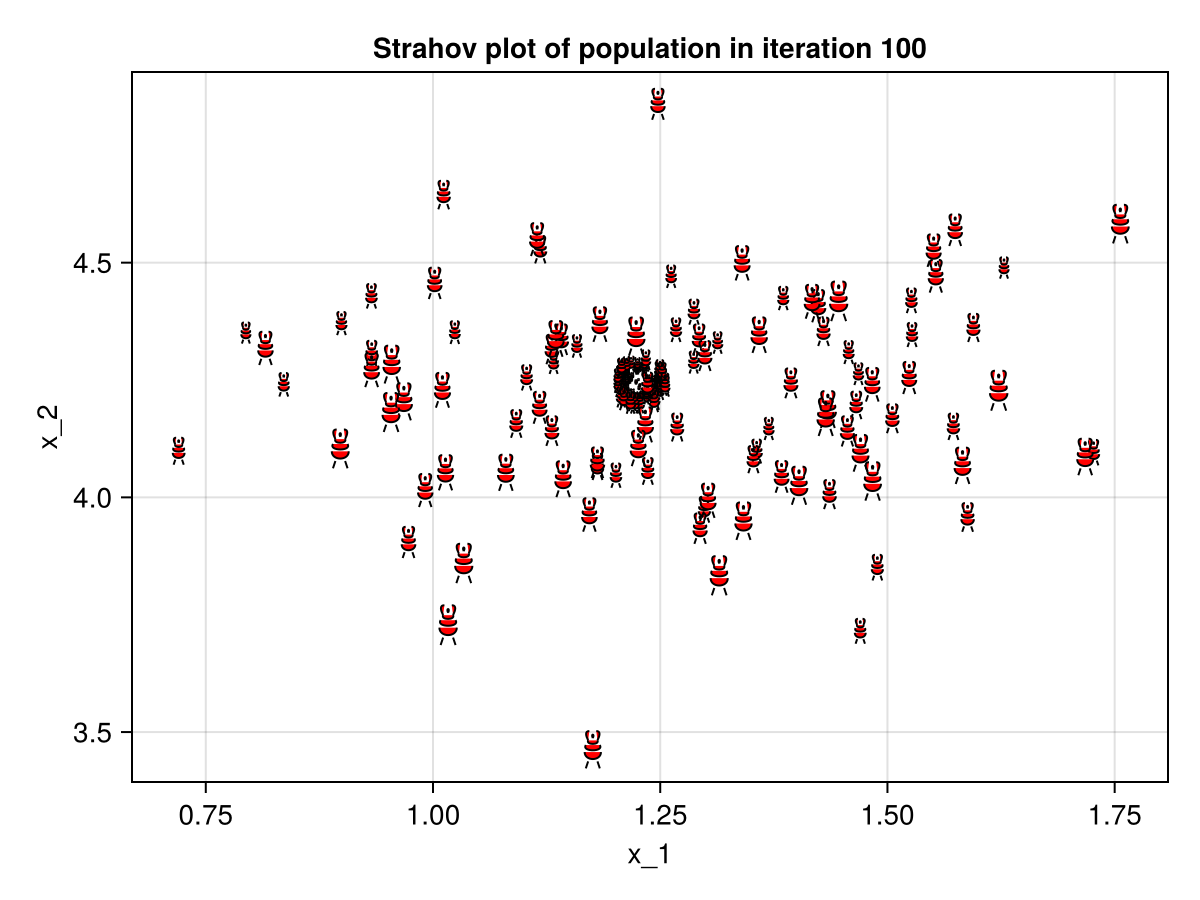

In [2]:
problem_set = simple_problems
problem_id = 2
constraints = problem_set[problem_id].constraints
pop_size = 100
dimension = problem_set[problem_id].dimension

objective_function  = problem_set[problem_id].objective
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_stochastic_tournament, 30, 3, constraints, 0.4)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_keep_best_n_stoch, pop_size, constraints, 0.4)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination; constraints=constraints)
EO.compare(solution, problem_set[problem_id])
EO.strahov_plot(solution.pop_history, 100) # can pass x_i= and y_i= to specify which two parameters of the solution should be plotted

### MOEA
Multi objective ES, where one objective dimension is the objective itself and the second objective is sum of all constraint violations.

This approach has a problem caused by the nature of the pareto front, where a solution with great objective value, but terrible constraint violation can be considered as dominating.

top_x: Real[1.2565453279317007, 4.223403150532907]
top_f: -0.09046785557117798
violations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
opt_x: -0.0958250414180359
opt_f: [1.227971352607526, 4.245373366122749]


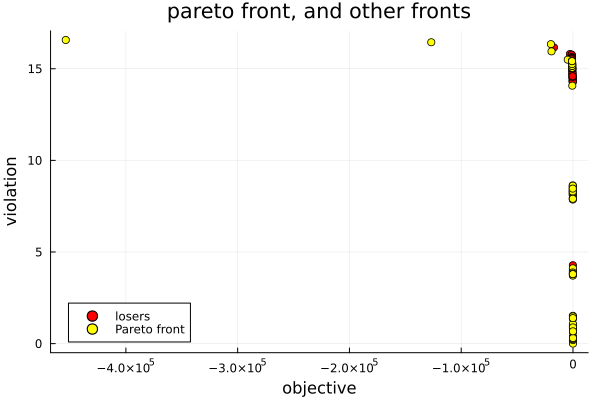

In [3]:
problem_set = simple_problems
problem_id = 2
constraints = problem_set[problem_id].constraints
pop_size = 100
dimension = problem_set[problem_id].dimension

f_pens(x::RealChromosome, constraints::Vector{EO.Constraint}) = sum(EO.Gs(x, constraints))

F = typeof(enclose_arguments(EO.f_weighted_sum, ones(dimension)))
objective_function  = EO.MultiObjFunction{F}([problem_set[problem_id].objective, enclose_arguments(f_pens, constraints)])
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, 30, 5)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_NSGA, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)
EO.compare(solution, problem_set[problem_id])
EO.plot_pareto_fronts(solution.pop_history[end])

### Adaptive penalization
The objective function is penalized by the sum of constraint violations, multiplied by rg(t) which controls the exploration exploitation tradeoff.

top_x: Real[0.9212943823613644, 0.8487047458466763]
top_f: 0.8794315862482822
violations: [0.0, 7.869312393154738e-5, 0.0, 0.0, 0.0, 0.0]
--------------------------------
opt_x: 0.7499
opt_f: [-0.7070360700371706, 0.5000000043336068]


"here"

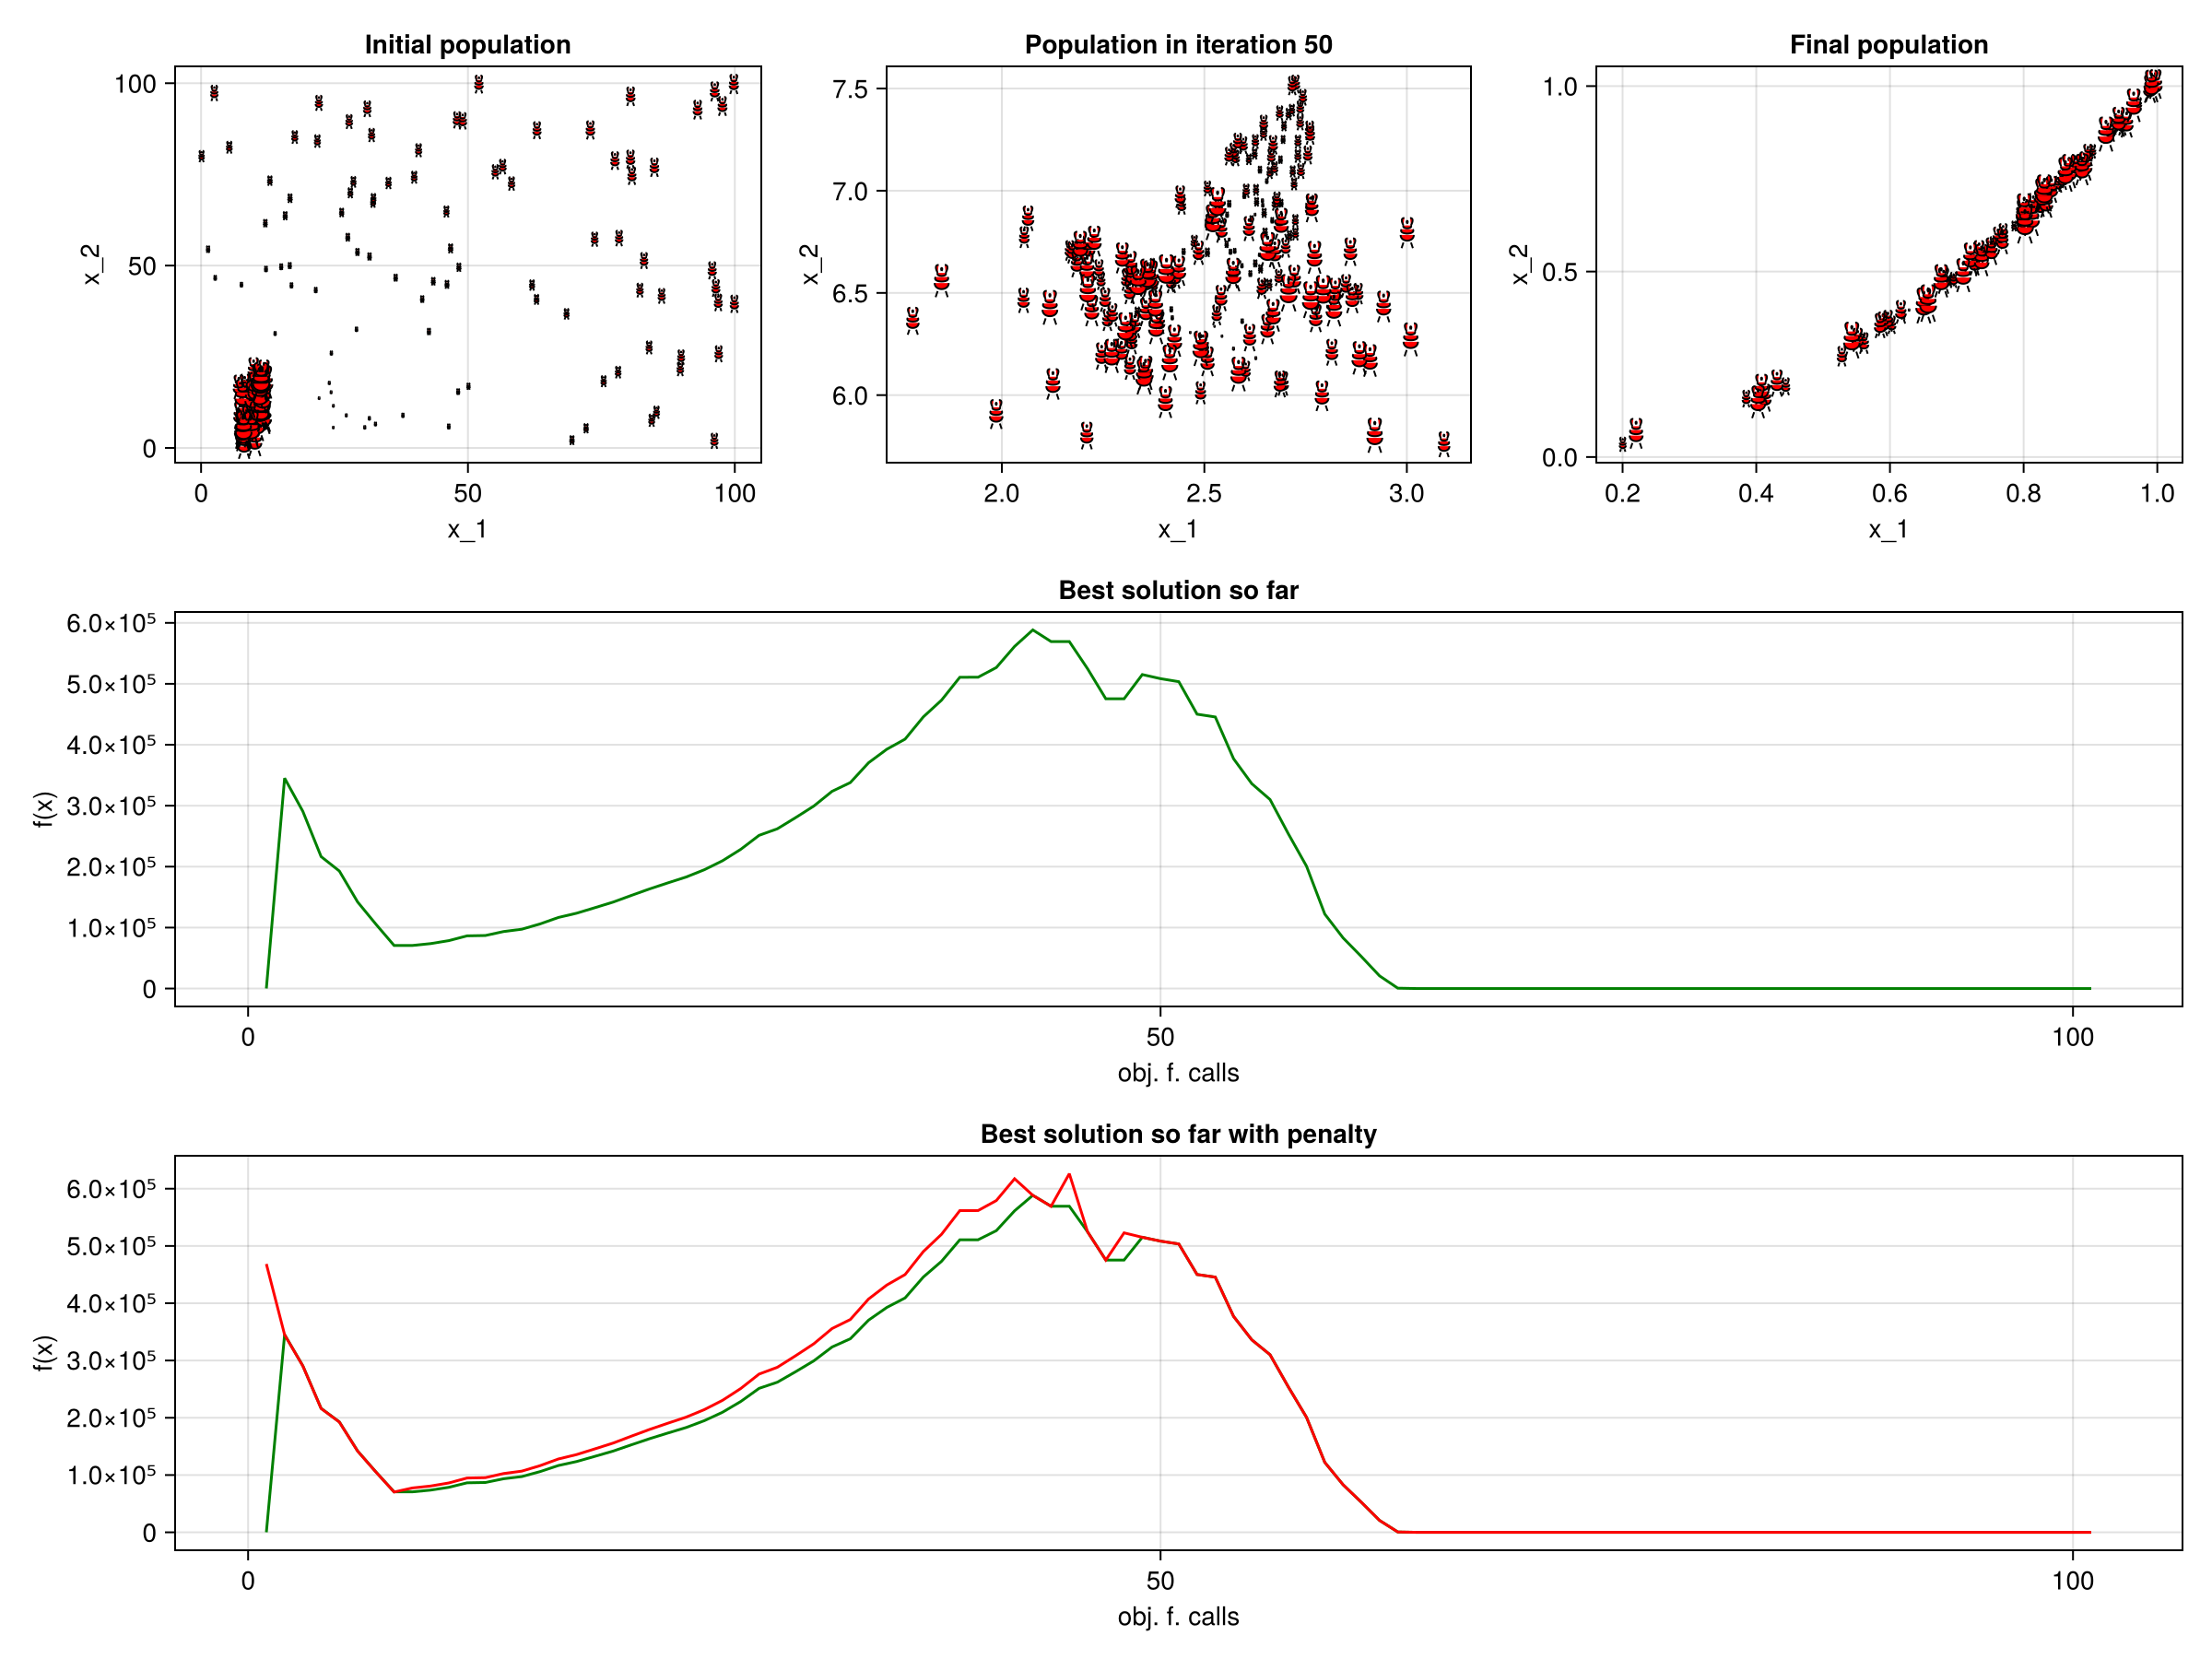

In [4]:
problem_set = simple_problems
problem_id = 3
constraints = problem_set[problem_id].constraints
penatly = EO.p_non_linear   # rg*sum(G(constraints)).^2

pop_size = 100
dimension = problem_set[problem_id].dimension

objective_function  = problem_set[problem_id].objective
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, 30, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_keep_best_n, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination; constraints=constraints, penalty=penatly);
EO.compare(solution, problem_set[problem_id])
EO.plot_results(solution)       # can pass x_i= and y_i= to specify which two parameters of the solution should be plotted

### Adaptive penalization, vectorized rg
The objective function is penalized by the vector of constraint violations, multiplied by vector rg(t) which controls the exploration exploitation tradeoff.
Each constraint has separate rg_i(t), which allows for faster convergence, because only the violated constraints are being penalized, not distracting the rest of the optimization.

-6961.813721809882
top_x: Real[14.095000048634898, 0.8429609266603616]
top_f: -6961.813721809882
violations: [2.5805871928241686e-7, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
opt_x: -6961.8138755801
opt_f: [14.095, 0.8429607892154796]


"here"

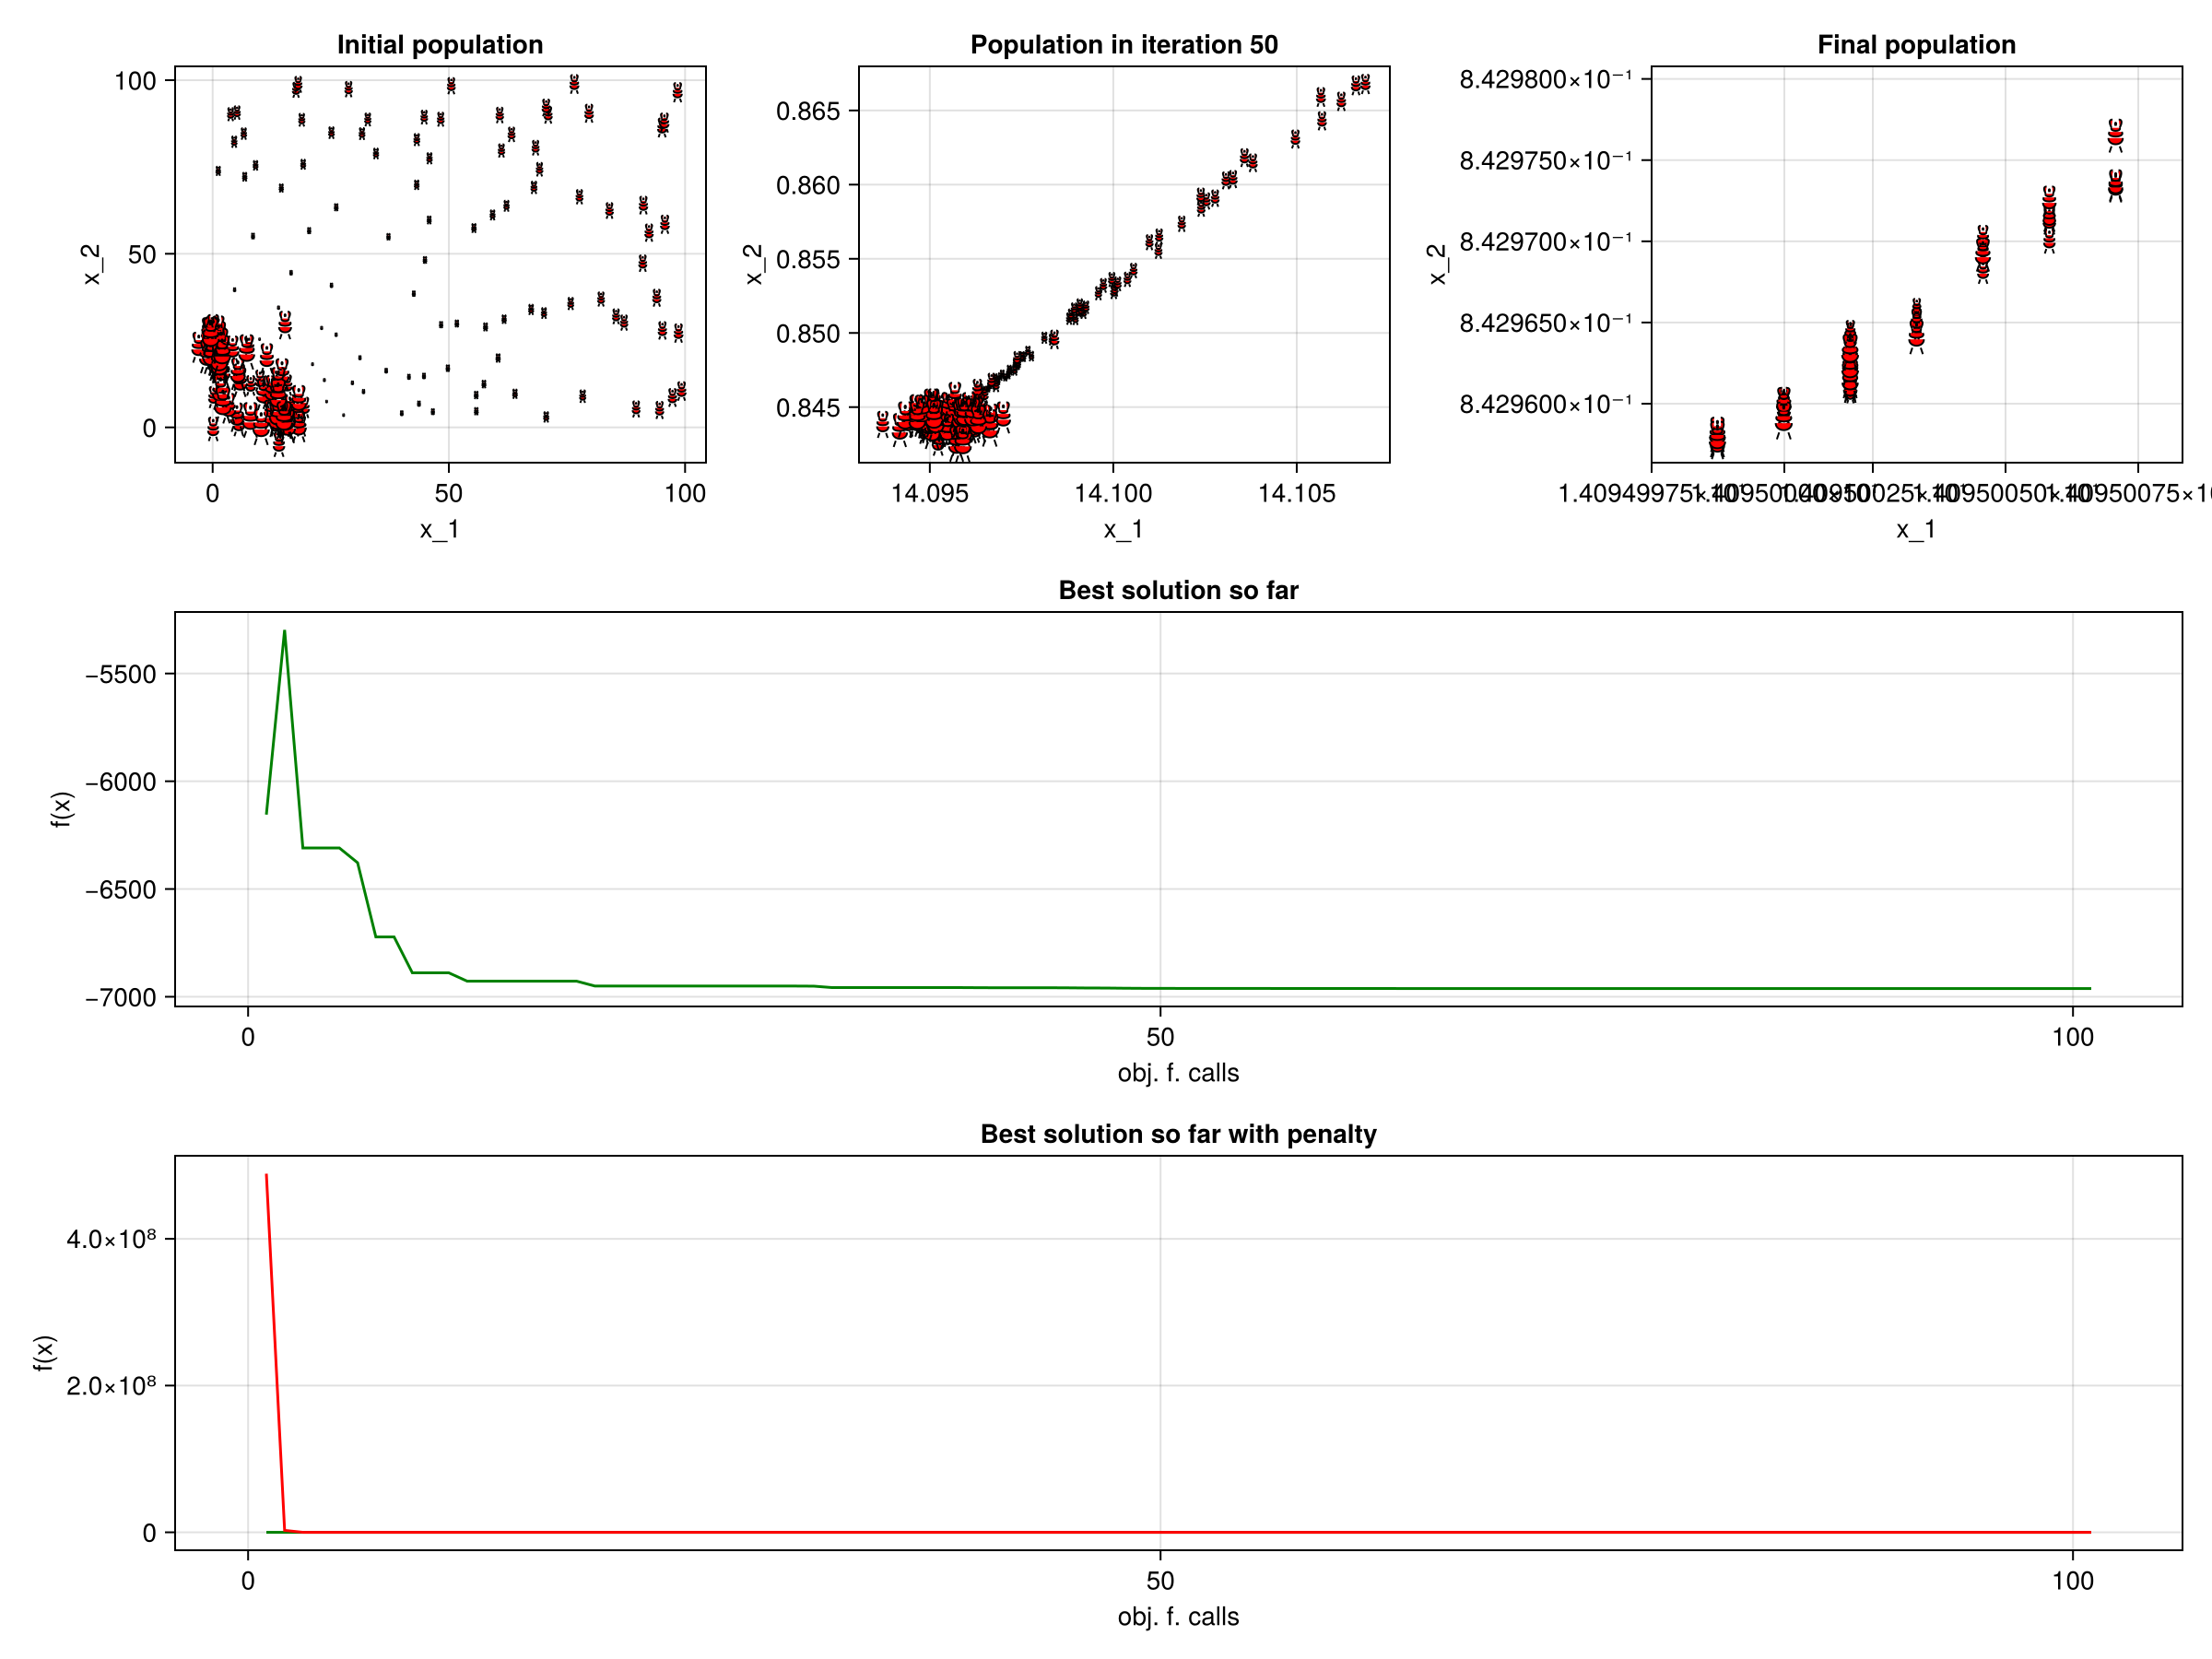

In [5]:
problem_set = simple_problems
problem_id = 1
constraints = problem_set[problem_id].constraints
penatly = EO.p_non_linear   # rg*sum(G(constraints)).^2

pop_size = 100
dimension = problem_set[problem_id].dimension

objective_function  = problem_set[problem_id].objective
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, 30, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_keep_best_n, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination, "vec"; constraints=constraints, penalty=penatly);
EO.compare(solution, problem_set[problem_id])
EO.plot_results(solution)       # can pass x_i= and y_i= to specify which two parameters of the solution should be plotted

### MMOEA
The improvement of MOEA where sum of all constraint violations was one objective. Now each contraint violation is its own objective.

top_x: Real[13.088098239006946, -0.7165662621788969]
top_f: -8861.606292470844
violations: [1.9035370462907366, 0.11026647569536863, 0.0, 0.0, 0.7165662621788969, 0.0]
--------------------------------
opt_x: -6961.8138755801
opt_f: [14.095, 0.8429607892154796]


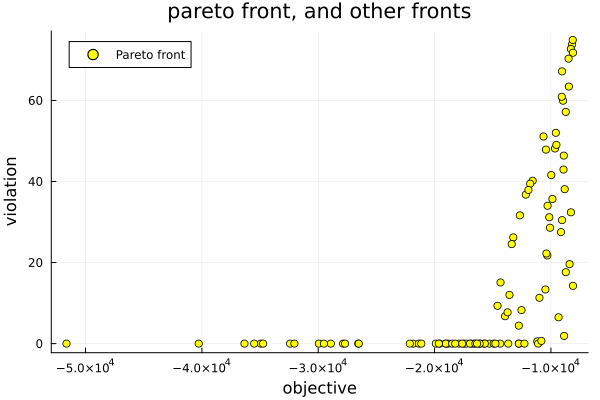

In [6]:
problem_set = simple_problems
problem_id = 1
constraints = problem_set[problem_id].constraints
pop_size = 100
dimension = problem_set[problem_id].dimension

f_pens(x::RealChromosome, constraints::Vector{EO.Constraint}) = sum(EO.Gs(x, constraints))

objectives = Vector{Any}([problem_set[problem_id].objective])
for constraint in constraints
    push!(objectives, constraint)
end

F = typeof(f_pens)
objective_function  = EO.MultiObjFunction{F}(objectives)
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, 30, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_NSGA, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)
EO.compare(solution, problem_set[problem_id])
EO.plot_pareto_fronts(solution.pop_history[end])

### Kim Jong Un

Constraint vialation is being handled by imposing the death penalty.

top_x: Real[3.018481100420789, 6.368951342035556]
top_f: -2873.0140857430288
violations: [94.19955507374944, 0.0, 9.98151889957921, 0.0, 0.0, 0.0]
--------------------------------
opt_x: -6961.8138755801
opt_f: [14.095, 0.8429607892154796]


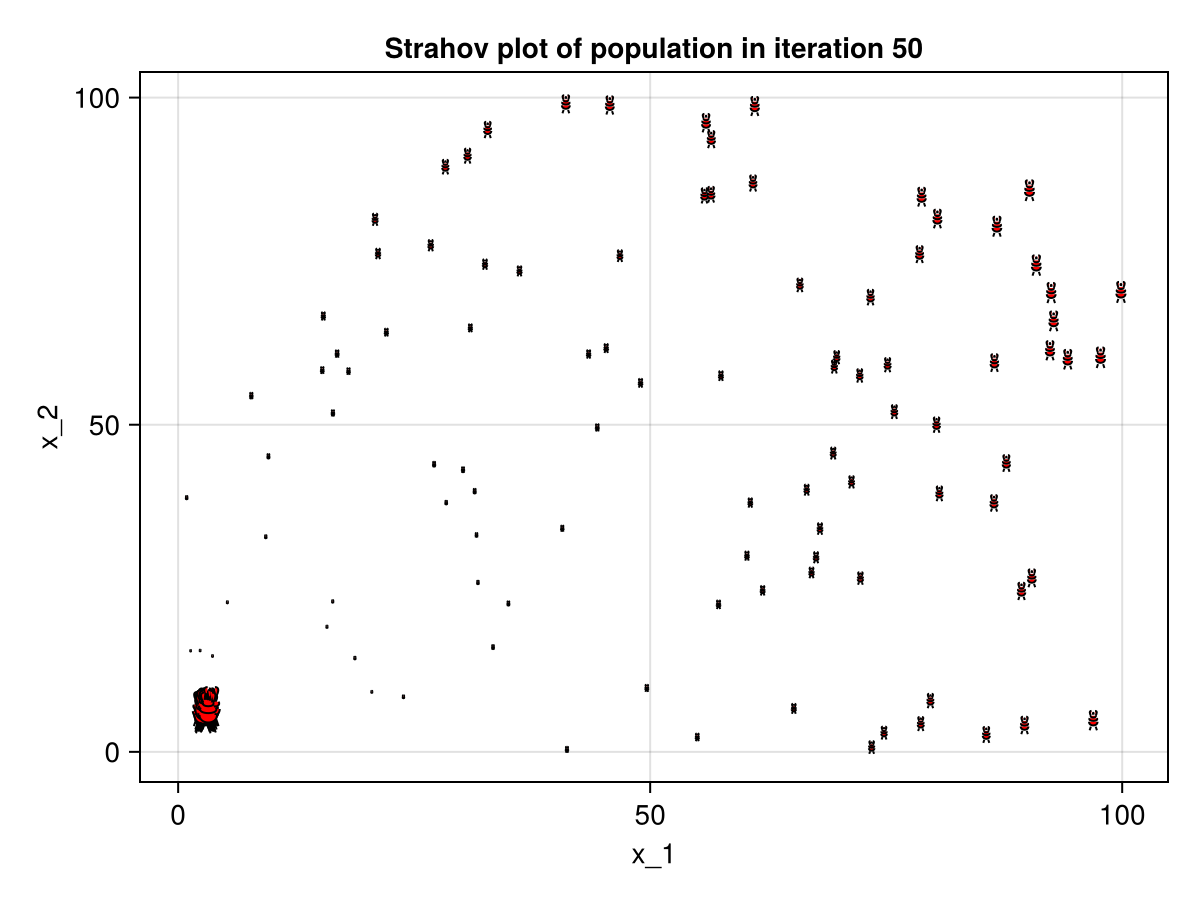

In [7]:
problem_set = simple_problems
problem_id = 1
constraints = problem_set[problem_id].constraints
penatly = (x...) -> EO.death_penalty(x..., Inf)     # real numbers led to huge violations, strict measures had to be carried out

pop_size = 100
dimension = problem_set[problem_id].dimension

objective_function  = problem_set[problem_id].objective
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, 30, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_keep_best_n, pop_size)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination; constraints=constraints, penalty=penatly);
EO.compare(solution, problem_set[problem_id])
EO.strahov_plot(solution.pop_history, 50) # can pass x_i= and y_i= to specify which two parameters of the solution should be plotted

### NSGA-II with modified tournament operator

The best of here implemented multi objective approaches. The violation of constraints is also added into the binary tournament, preffering less violating solutions.
This algorithm mas much denser pareto front around the looked for optimum.

top_x: Real[11.957729690168895, -2.1906547132060115]
top_f: -10919.733220794367
violations: [0.0, 4.390058265671783, 1.042270309831105, 0.0, 2.1906547132060115, 0.0]
--------------------------------
opt_x: -6961.8138755801
opt_f: [14.095, 0.8429607892154796]


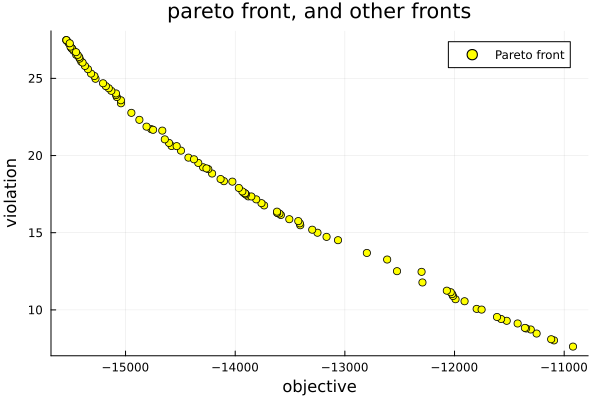

In [8]:
problem_set = simple_problems
problem_id = 1
constraints = problem_set[problem_id].constraints
pop_size = 100
dimension = problem_set[problem_id].dimension

f_pens(x::RealChromosome, constraints::Vector{EO.Constraint}) = sum(EO.Gs(x, constraints))

F = typeof(enclose_arguments(EO.f_weighted_sum, ones(dimension)))
objective_function  = EO.MultiObjFunction{F}([problem_set[problem_id].objective, enclose_arguments(f_pens, constraints)])
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = enclose_arguments(EO.s_tournament, 30, 3)
crossover           = enclose_arguments(EO.cr_parent_sum, pop_size)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_cNSGA, pop_size, constraints)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination)
EO.compare(solution, problem_set[problem_id])
EO.plot_pareto_fronts(solution.pop_history[end])

### ASCHEA
* selection breeding feasible solutions with unfeasible
* adaptive penalization
* selection selecting chosen percentage of population to be feasible and fills the rest with the best unfeasibles.
* (the rg is vectorized when the "v" in arguments is present)

-6447.883377514304
top_x: Real[14.306652935795597, 1.3109141373888045]
top_f: -6447.883377514304
violations: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
opt_x: -6961.8138755801
opt_f: [14.095, 0.8429607892154796]


"here"

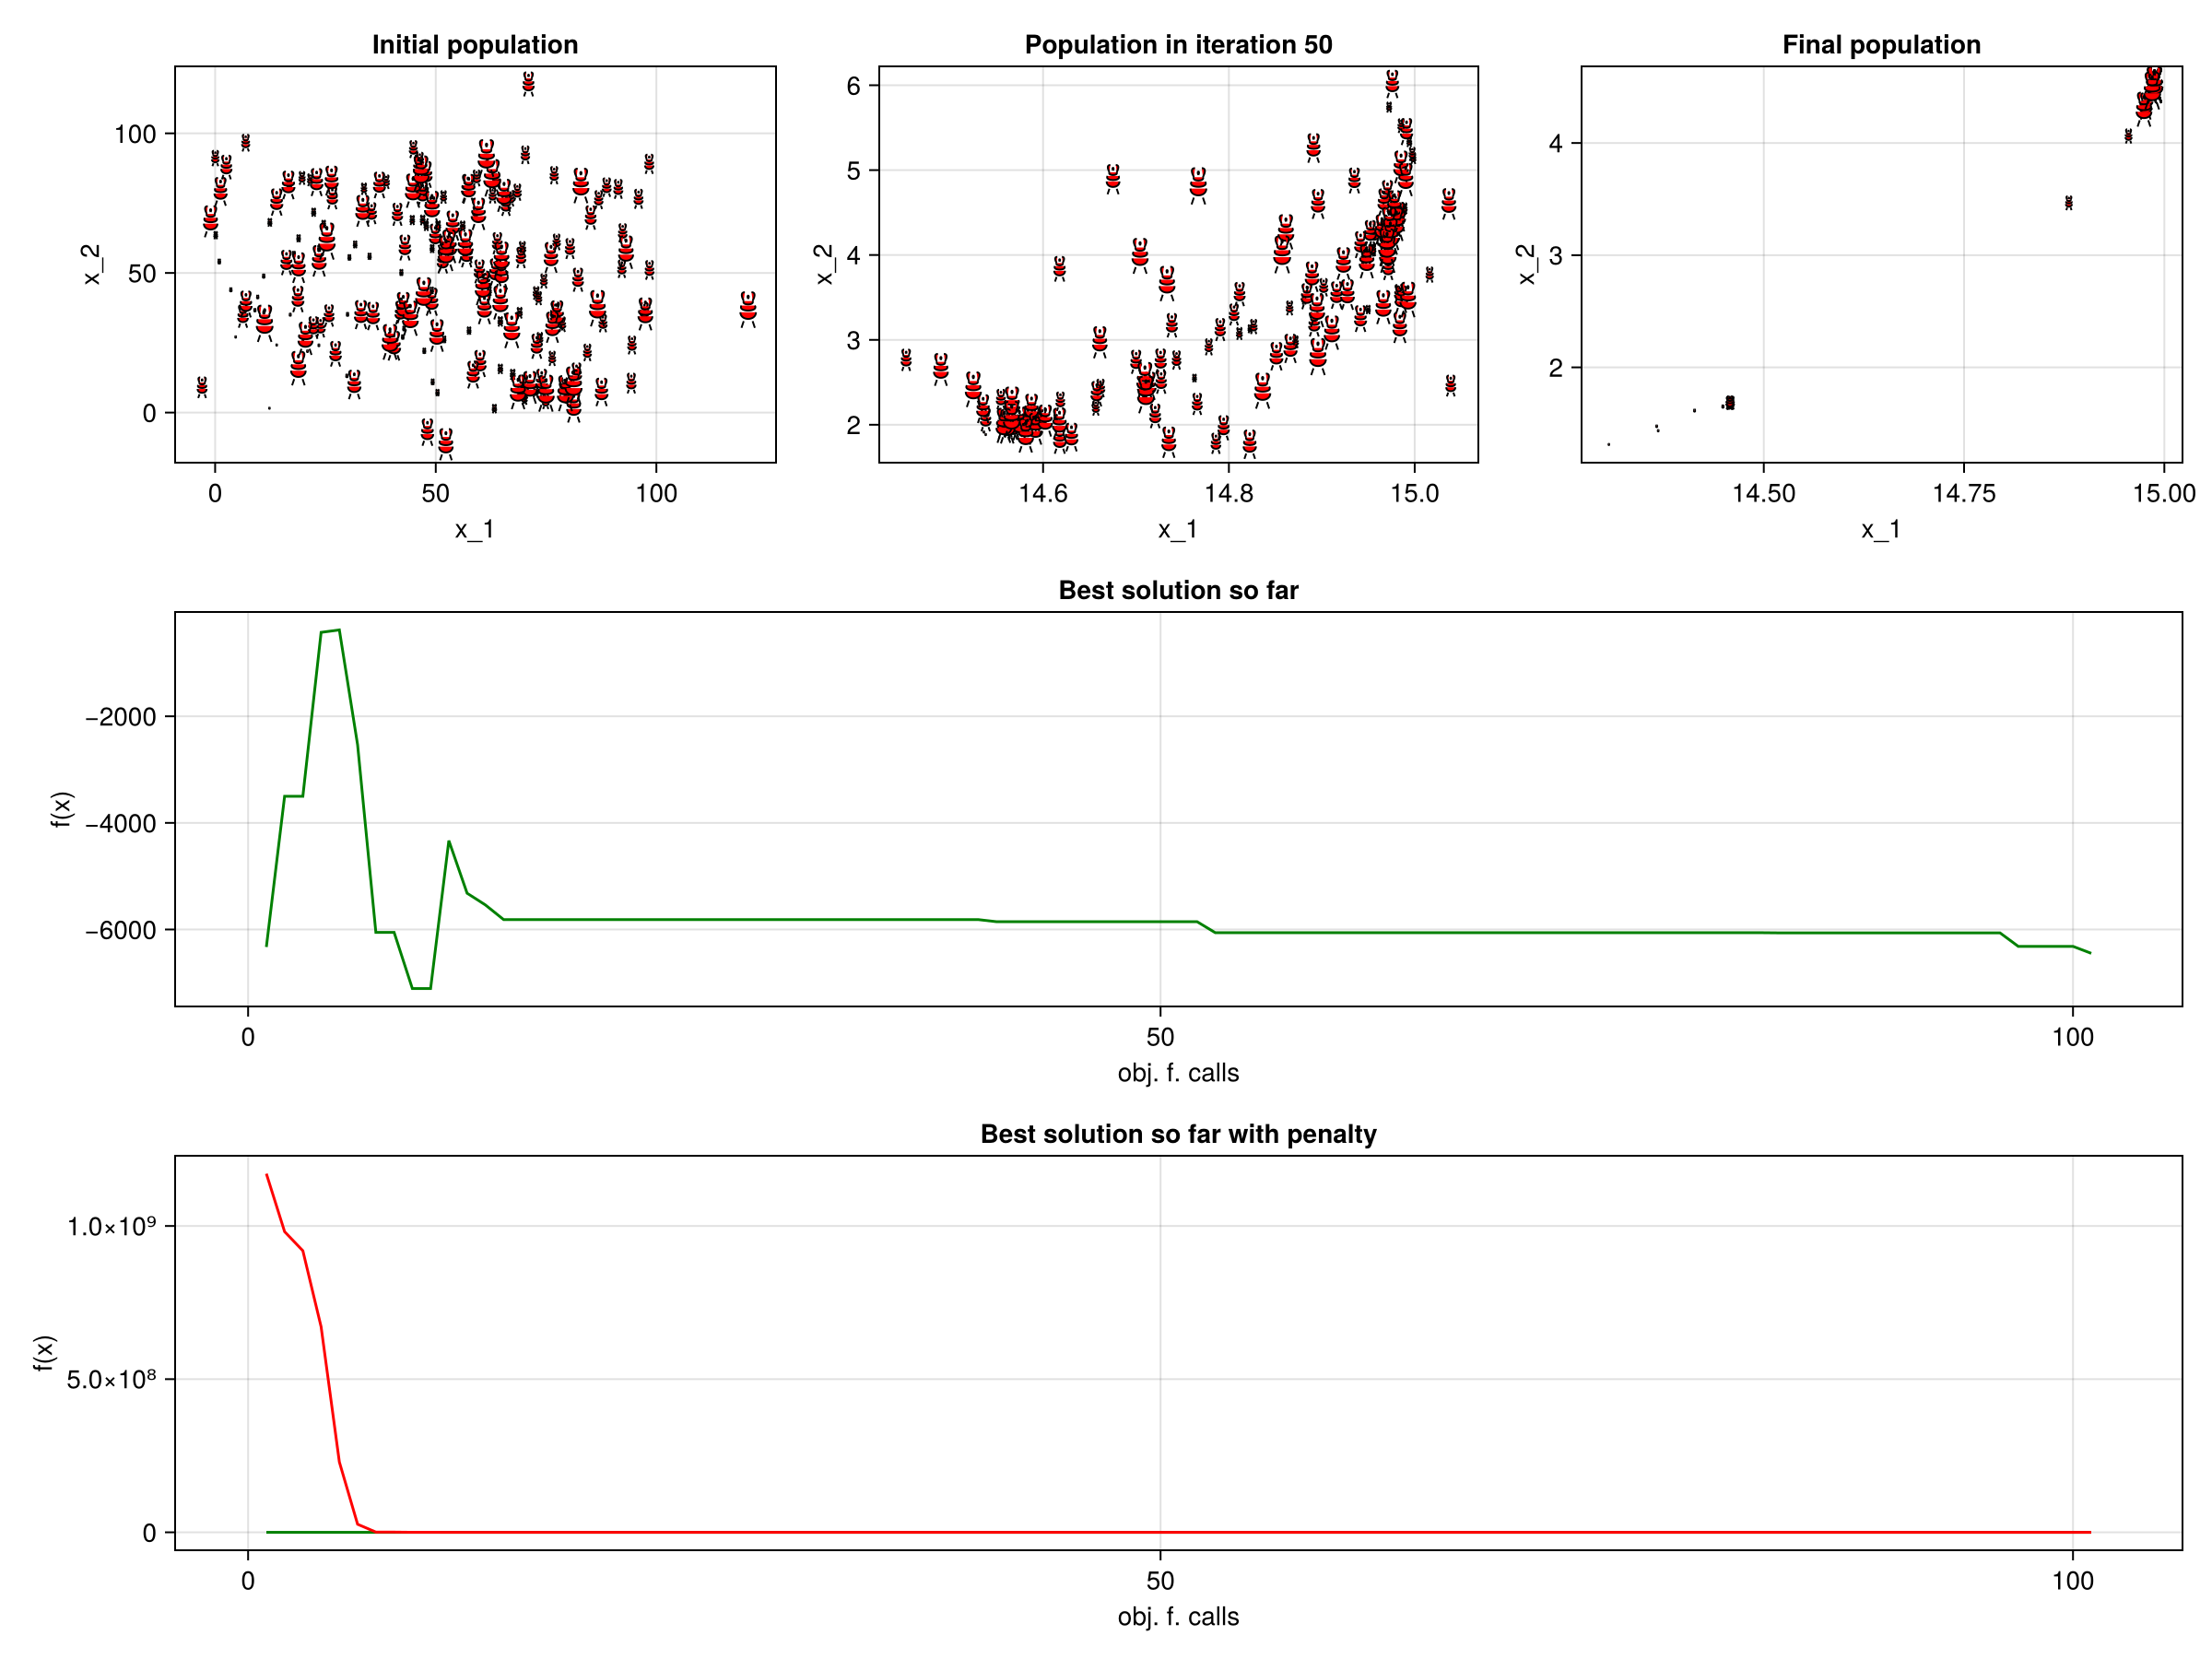

In [9]:
problem_set = simple_problems
problem_id = 1

constraints = problem_set[problem_id].constraints
penatly = EO.p_non_linear   # rg*sum(G(constraints)).^2

pop_size = 100
dimension = problem_set[problem_id].dimension

objective_function  = problem_set[problem_id].objective
initialization      = enclose_noargs(interval_real_initialization, dimension, pop_size, objective_function, 0, 100)
selection           = EO.s_identity
crossover           = enclose_arguments(EO.cr_ASCHEA, pop_size, 1/3, constraints)
mutation            = enclose_arguments(gaussian_preturbation!, 0.25)
replacement         = EO.enclose_replacement(EO.r_ASCHEA, pop_size, 1/3, constraints)
termination         = enclose_argument(iteration_termination, pop_size*100)

solution = solvink_hart(objective_function, initialization, selection, crossover, mutation, replacement, termination, "v"; constraints=constraints, penalty=penatly)
EO.compare(solution, problem_set[problem_id])
EO.plot_results(solution)       # can pass x_i= and y_i= to specify which two parameters of the solution should be plotted

# ----------------------------------------------------------------------------------------

## Benchmark results
Interactive graphs of average performance of implemented methods on chosen problems.
All algorithms were run for 100 times, with population 100 and 100 generations, with initial gaussian mutation probability of 0.25.
The details of the benchmarking setup can be seen in the `hw2_benchmark.ipynb`.

You can either inspect the averge performance of one chosen algorithm on one particular problem in the first cell in each subsection (one subsection for 2D problems, one for ND problems). Or compare average performances of any number of chosen number of algorithms on all problems in given cathegory (simple 2D, or unsimple ND).

The currently displayed graphs do not show all the algorithms for the sake of visibility, I tried to keep displayed at least one algorithm representative for certain strategy of solving the constrained problems (stochastic ranking, adaptive penalization, multiobjective approach and ASCHEA).

The vector with names of the implemented algorithms is in the cells, only with commented out unplotted ones. Rg stands for adaptive penalization, and the suffix `_vec` stands for the use of vectorized `rg`. Kim starts for the death penalty constraint violtion handling.


In [10]:
# load if u did not use the upper part of the notebook
using EO
simple_problems = EO.setup_simple_problems() # definitions of problems g06,g08,g11,g24
simple_solutions = [p.solution_v for p in simple_problems]
unsimple_problems = EO.setup_unsimple_problems() # definitions of problems g04, g05, g09 and g21.
unsimple_solutions = [p.solution_v for p in unsimple_problems];

### simple problems

Two dimensional problems, fairy easy to achieve (in my opinion) satisfying result.

rg 100

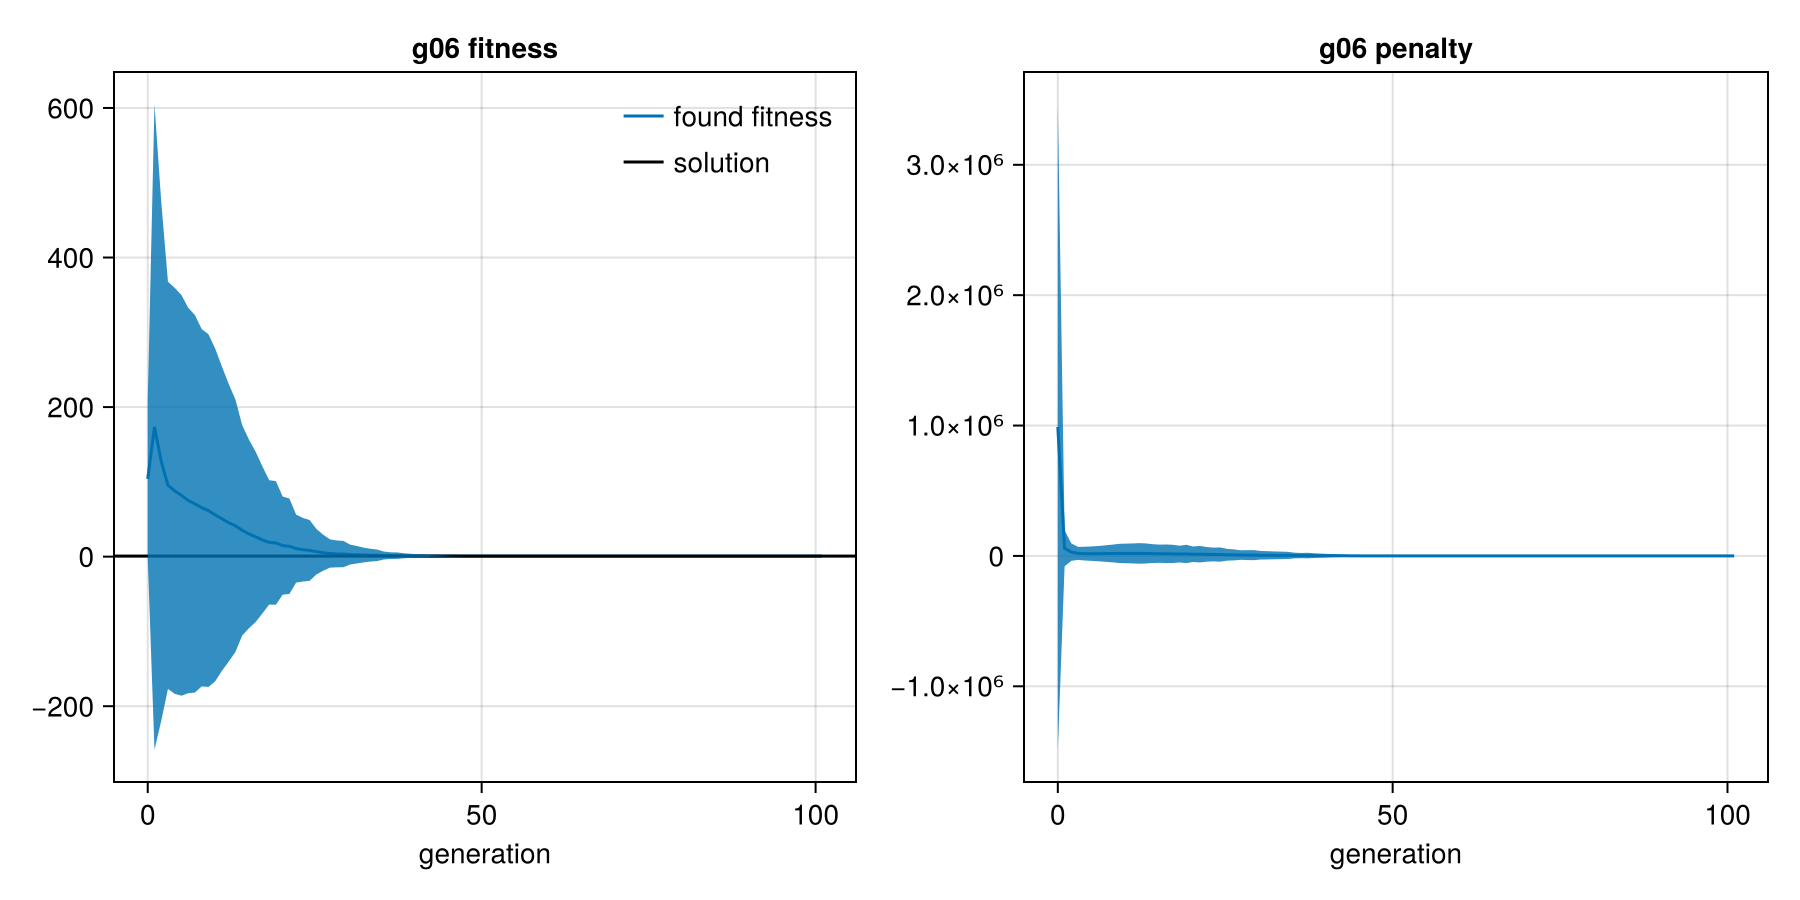

In [11]:
# plot performance of single algorithm on given simple problem
problem_id = 3
EO.plot_easy_benchmark(problem_id, "rg", simple_solutions[problem_id])

In [12]:
# plot performance of selected algorithms on all simple problems
algs = [#= "stoch", "aschea", "aschea_vec", "kim", "rg", "rg_vec",  =#"MOEA", "MMOEA", "NSGA"]
algs = ["stoch", "aschea", #= "aschea_vec", "kim",  =#"rg", #= "rg_vec",  =##= "MOEA", "MMOEA",  =#"NSGA"]
EO.plot_easy_benchmark(algs, simple_solutions)

NSGA 10000

### Unsimple problems
N dimensional problems. Proved to be much harder than expected.

NSGA 100

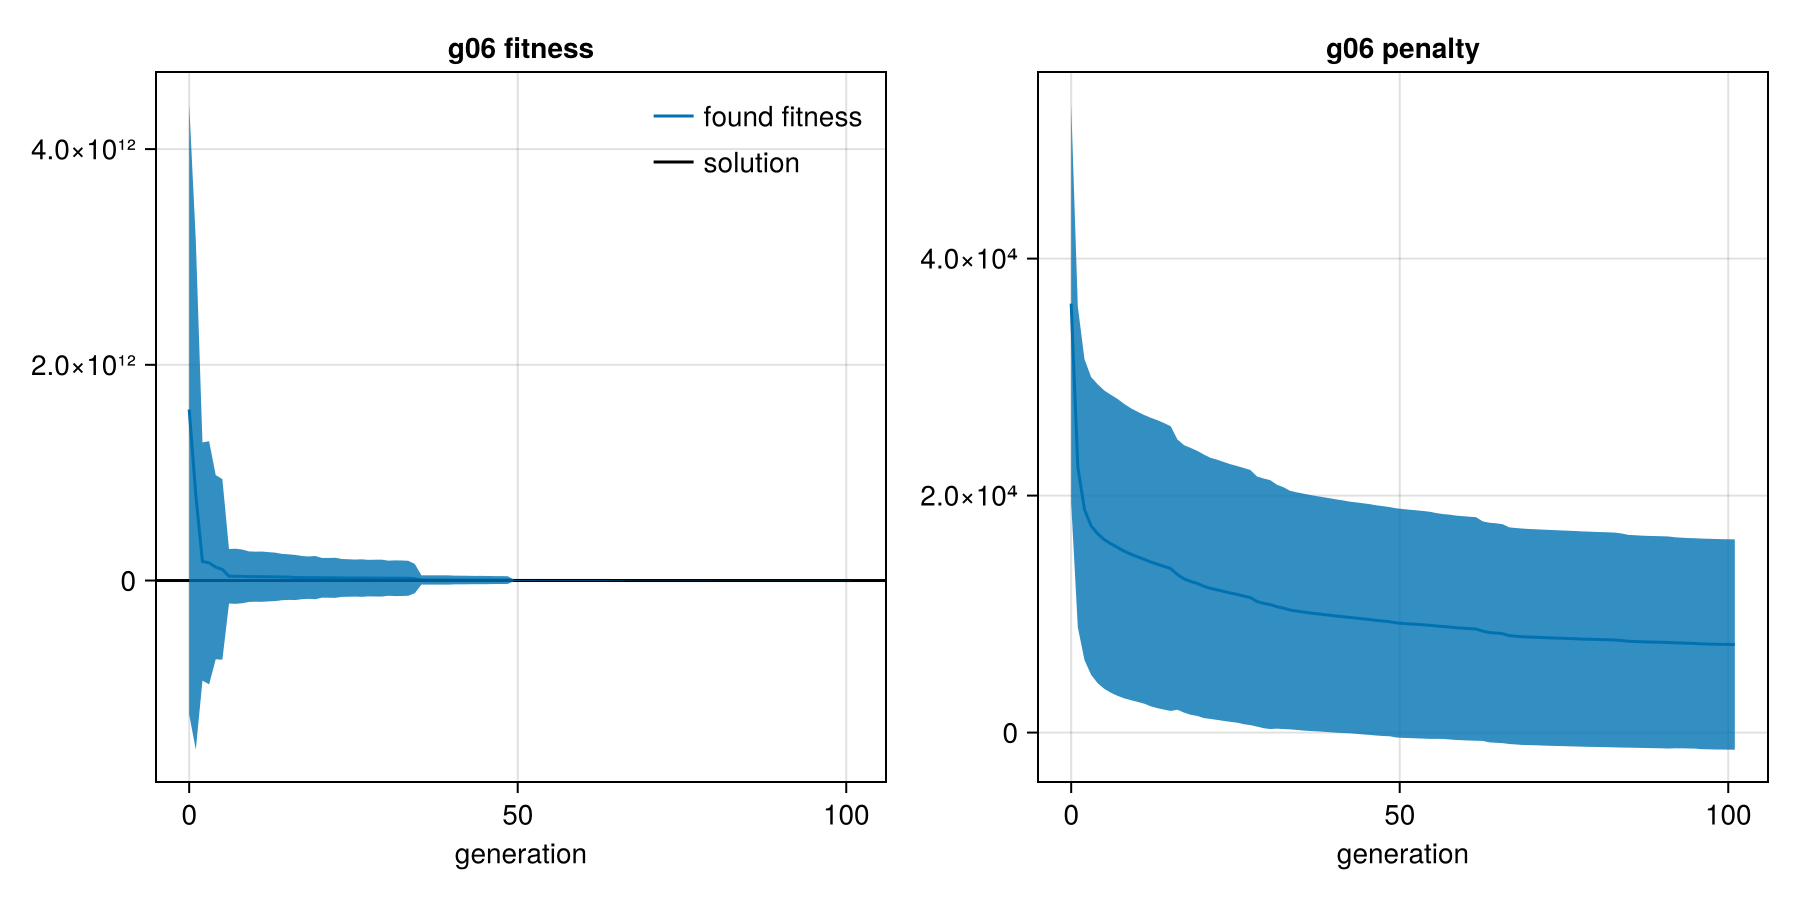

In [13]:
# plot performance of single algorithm on given unsimple problem
problem_id = 3
EO.plot_hard_benchmark(problem_id, "NSGA", unsimple_solutions[problem_id])

In [14]:
# plot performance of selected algorithms on all unsimple problems
algs = ["stoch", "aschea", #= "aschea_vec", "kim",  =#"rg", #= "rg_vec",  =##= "MOEA", "MMOEA",  =#"NSGA"]
EO.plot_hard_benchmark(algs, unsimple_solutions)

## Conclusions

Vectorized rg has in some cases worse average performance than scalar rg, however if it succeeds it is more precise.
Penalized fitness seems better in all aspects than stochastic ranking in 2D problems, however stochastic ranking in higher dimensions seems to be more reliable.

Death penalty seems to be useless.

The best multiobjective is NSGA-II with modified binary tournament operator. The second best is MMOEA. And MOEA ist the worst as expected.

I have either badly implemented ASCHEA or it is worse than expected (I expected it to outperform rg in all cases, since it seems just like a more advanced rg). Maybe it would converge closer to the optimal solution, but require more function calls.

## AI acknowledgements
1. The constraints for the problem definitions were rewritten from the pdf into my code by GPT model, which saved at least an hour of work.
2. The crowding distance was implemented by AI, because i was curious how well it can code (line 43-126 in utils.jl).
3. The beatle image for Strahov plot was generated by chat GPT from prompt "svg pth string of betle pls".